In [1]:
import sys
sys.path.append("../") # go to parent dir

import jax
import jax.numpy as jnp
import numpy as np
from matplotlib import pyplot as plt
import module.chebyshev_solver as chb

import optax
from tqdm import tqdm

In [2]:
key = jax.random.PRNGKey(5)

## 1. Problem
In this notebook we try to find the position and size of a guassian conductivity blob by giving the dirichlet and von-Neumann boundary conditions. We solve the heat equation:

$$
\nabla(k\,\nabla T) = 0
$$

The conductivity k will be modeled by exponentially decaying chebyshev coefficients.

In [134]:
solver = chb.Solver(N = 10)
xx = solver.xx
yy = solver.yy
grid = solver.grid
dims = (solver.N, solver.N)
mask = np.ones(dims)
mask[1:-1,1:-1] = 0
maskx = np.ones(dims)
maskx[:,1:-1] = 0
masky = np.ones(dims)
masky[1:-1,:] = 0
mask = jnp.array(mask)
ii, jj = jnp.meshgrid(jnp.arange(solver.N), jnp.arange(solver.N))
a = 1.4
index_decay = jnp.exp(-(ii+jj)/a)

k_cheby_init = jax.random.normal(key, shape = dims) * index_decay
k_cheby_init = k_cheby_init.at[0,0].set(k_cheby_init[0,0] + jnp.sum(index_decay)*2)
k_cheby_init = k_cheby_init.flatten()
k_init = (solver.I @ k_cheby_init).reshape(dims)

N_measure = 15
measurements = []
for i in range(N_measure):
    key, _ = jax.random.split(key)

    dirichlet_cheby = jax.random.normal(key, shape = dims) * index_decay
    dirichlet = (solver.I @ dirichlet_cheby.flatten()).reshape(dims)
    dirichlet *= mask

    sol = solver.solve(k_cheby_init, dirichlet)

    measurements.append((dirichlet, sol))

@jax.jit
def get_neumann(solution):
    jx = (solution["dx T"] * solution["k"]).reshape(dims)
    jy = (solution["dy T"] * solution["k"]).reshape(dims)

    neumann = jnp.concatenate((jx[:,0], jy[-1,:], jx[:,-1], jy[0,:]), axis = 0)
    return neumann

@jax.jit
def distance(solution, target_solution):
    neumann = get_neumann(solution)
    target_neumann = get_neumann(target_solution)

    return jnp.sum((neumann - target_neumann)**2)

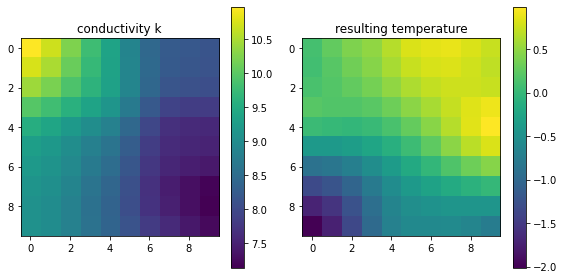

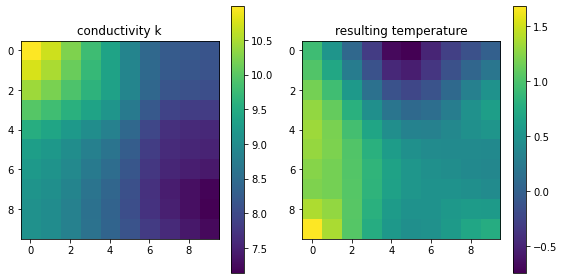

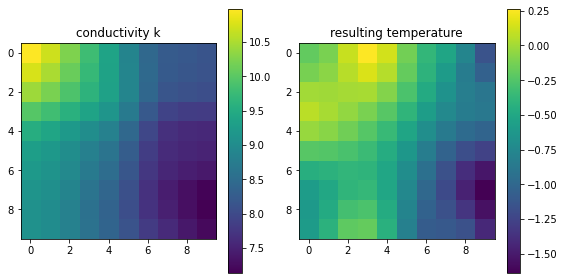

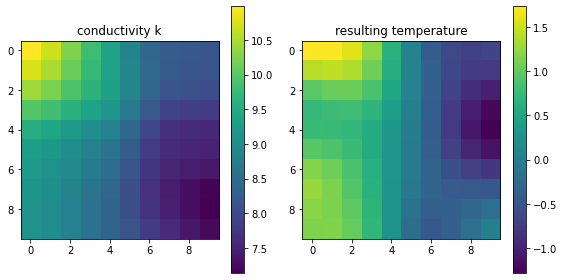

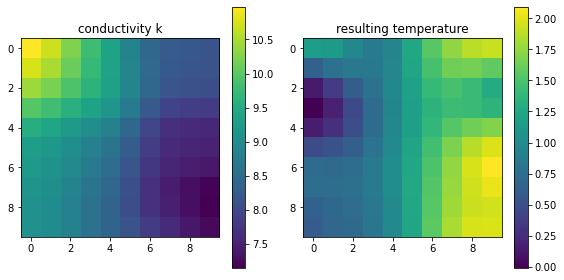

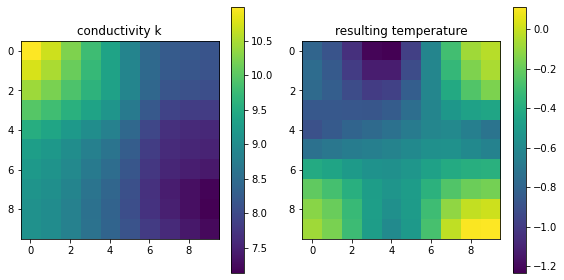

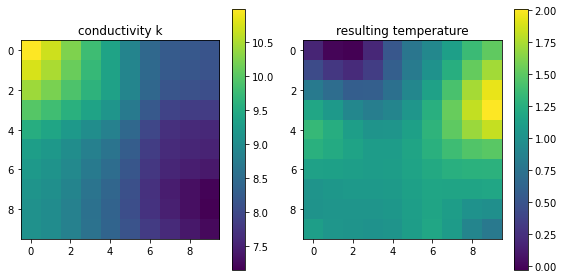

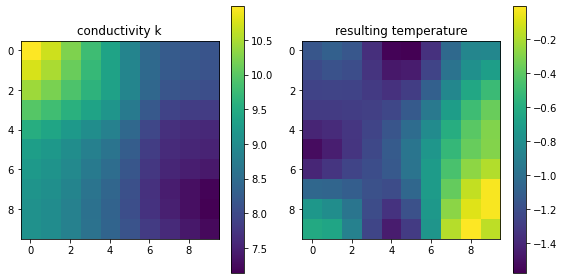

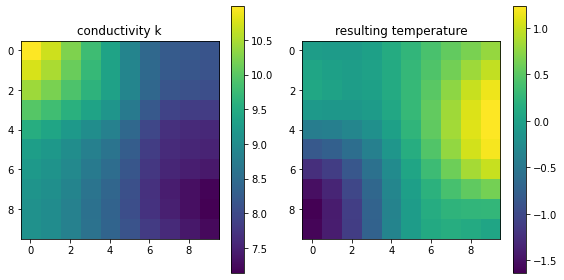

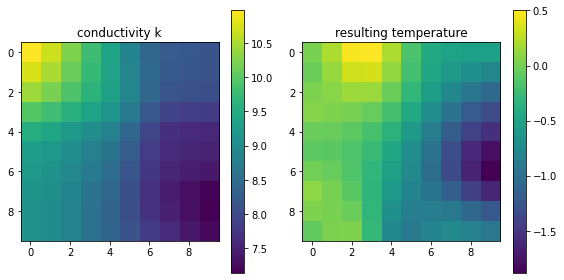

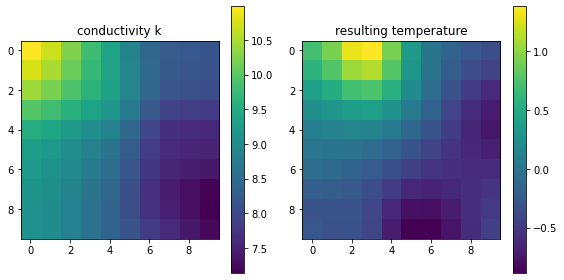

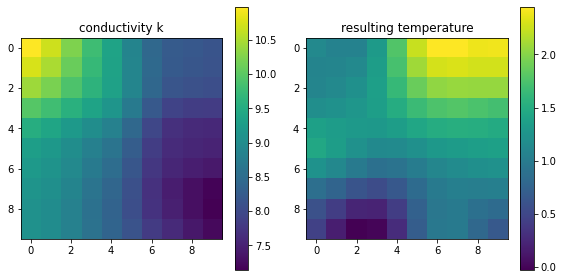

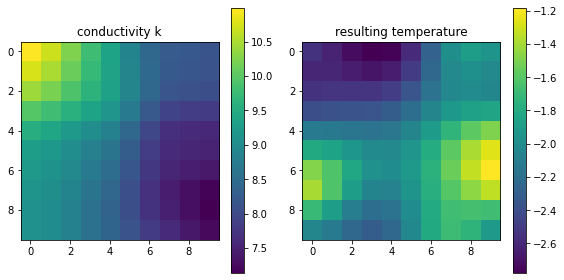

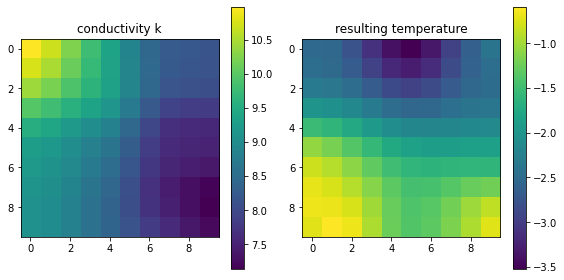

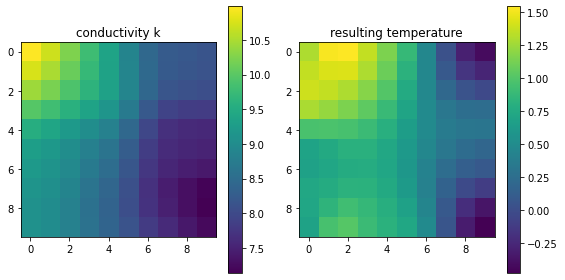

In [135]:
for i in range(N_measure):

    fig, axs = plt.subplots(1, 2, figsize = (8,4))
    im1 = axs[0].imshow(measurements[i][1]["k"].reshape(dims))
    plt.colorbar(im1, ax = axs[0])
    axs[0].set_title("conductivity k")
    im2 = axs[1].imshow(measurements[i][1]["T"].reshape(dims))
    plt.colorbar(im2, ax = axs[1])
    axs[1].set_title("resulting temperature")

    fig.tight_layout()

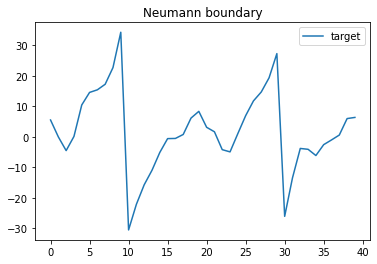

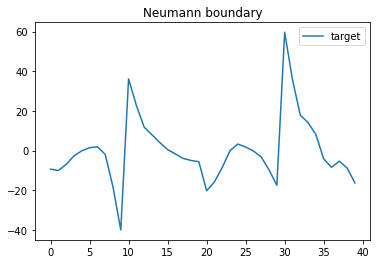

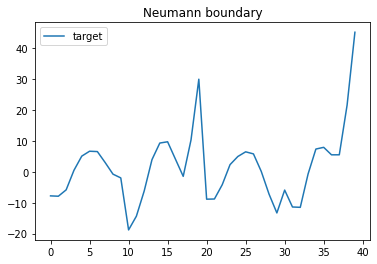

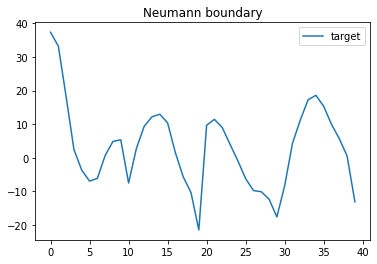

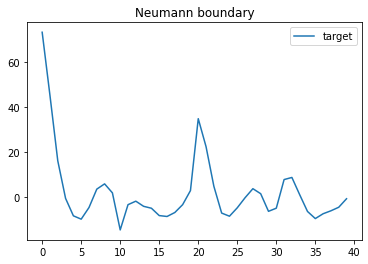

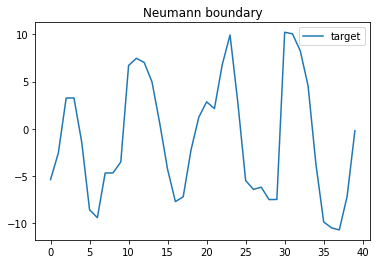

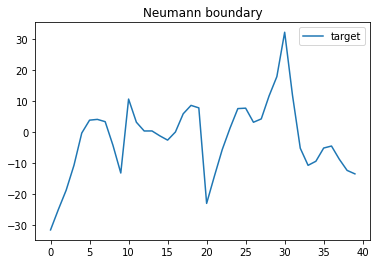

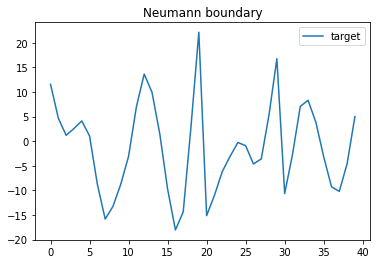

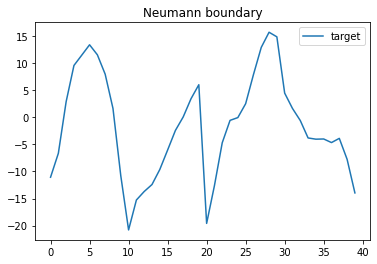

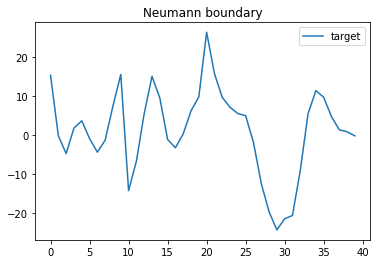

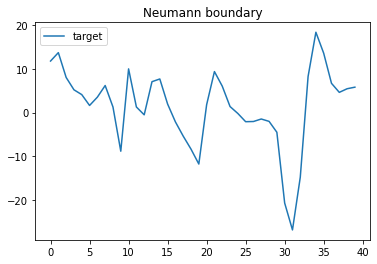

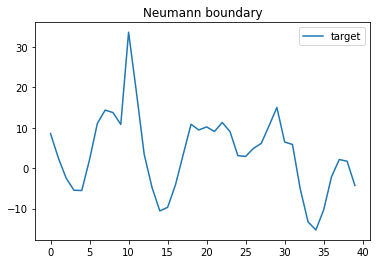

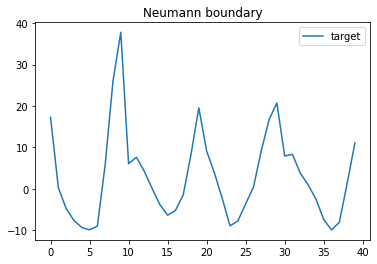

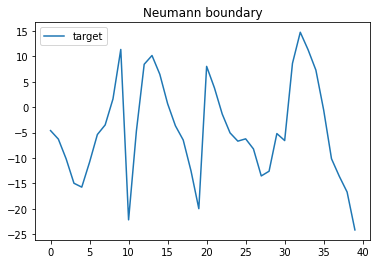

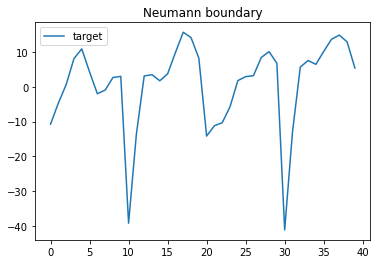

In [136]:
for i in range(N_measure):
    plt.figure()
    plt.plot(get_neumann(measurements[i][1]), label = "target")

    plt.legend()
    plt.title("Neumann boundary")

## 2. Initialise variational parameters

In [137]:
key, _ = jax.random.split(key)
k_cheby = jax.random.normal(key, shape = dims) * index_decay
k_cheby = k_cheby.at[0,0].set(k_cheby[0,0] + jnp.sum(index_decay))

k_param = {"coeff":k_cheby}

In [138]:
@jax.jit
def get_solution(k_param, dirichlet):
    k_cheby = k_param["coeff"] * index_decay
    k_cheby = k_cheby.flatten()
    solution = solver.solve(k_cheby, dirichlet)
    return solution


@jax.jit
def get_solution_internal(k_cheby_flat, dirichlet):
    solution = solver.solve(k_cheby_flat, dirichlet)
    return solution

## 3. Optimize parameters

In [139]:
@jax.jit
def loss(k_param):
    acc = 0
    for i in range(N_measure):
        acc += distance(get_solution(k_param, measurements[i][0]), measurements[i][1])
    return acc

@jax.jit
def loss_internal(k_cheby_flat):
    acc = 0
    for i in range(N_measure):
        acc += distance(get_solution_internal(k_cheby_flat, measurements[i][0]), measurements[i][1])
    return acc

g = jax.value_and_grad(loss)
h = jax.hessian(loss_internal)

In [140]:
# define
optimizer = optax.sgd(learning_rate=0.0003)

# initialise
optimizer_state = optimizer.init(k_param)

err = []

In [147]:
for i in tqdm(range(120)):
    val, grad = g(k_param)
    err.append(val)

    updates, optimizer_state = optimizer.update(grad, optimizer_state, k_param)

    k_param = optax.apply_updates(k_param, updates)

100%|██████████| 120/120 [00:07<00:00, 15.94it/s]


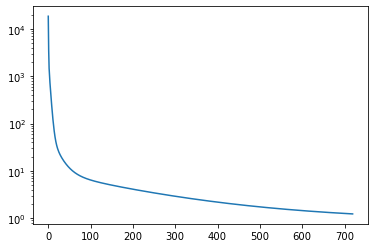

In [148]:
plt.plot(err)
plt.yscale("log")

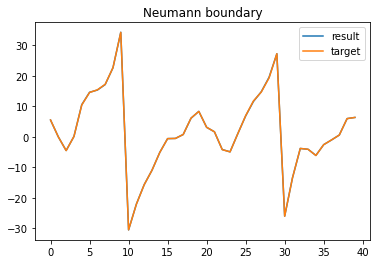

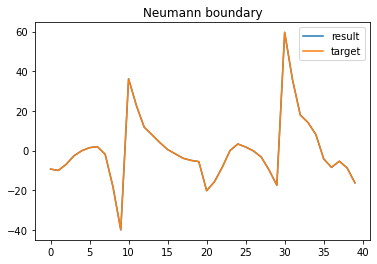

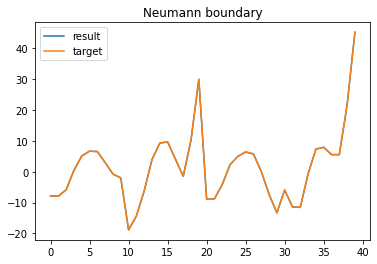

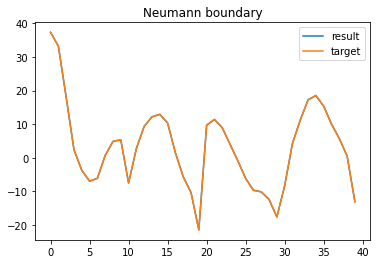

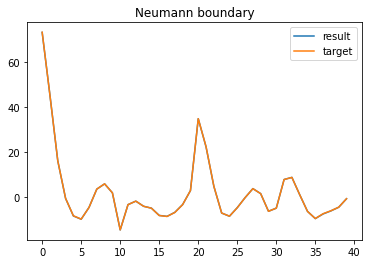

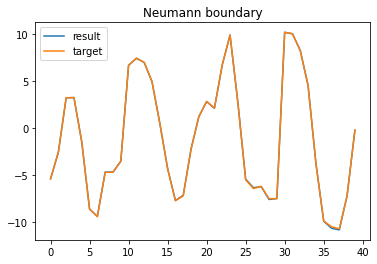

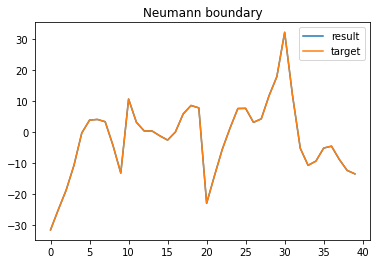

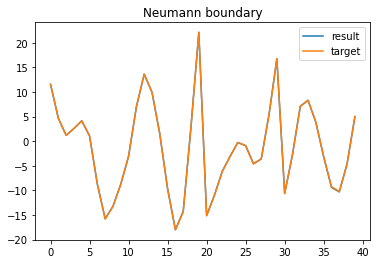

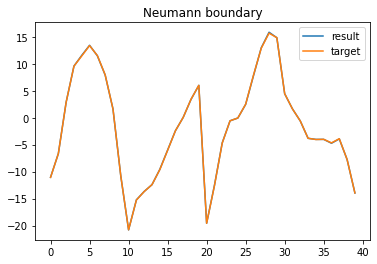

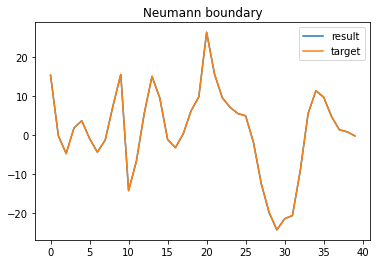

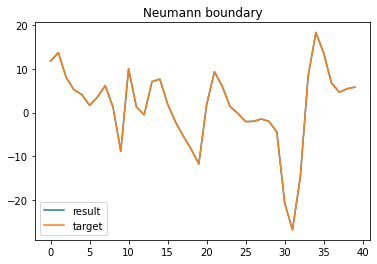

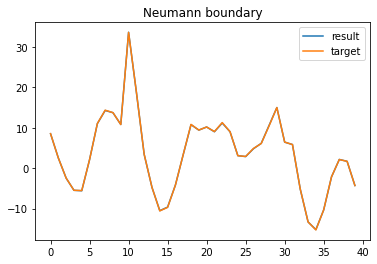

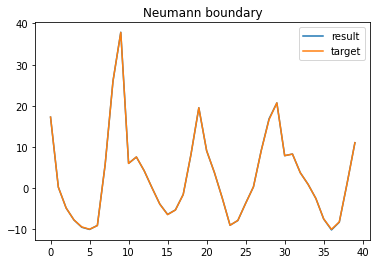

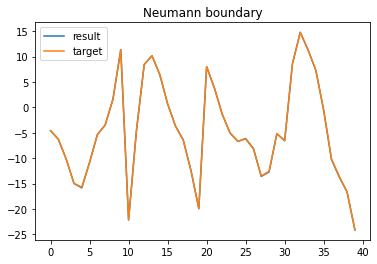

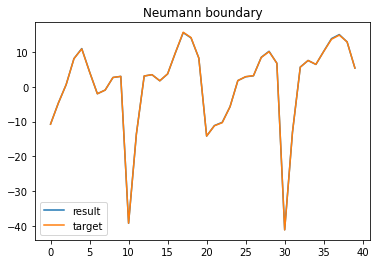

In [149]:
for i in range(N_measure):
    plt.figure()
    plt.plot(get_neumann(get_solution(k_param, measurements[i][0])), label = "result")
    plt.plot(get_neumann(measurements[i][1]), label ="target")

    plt.legend()
    plt.title("Neumann boundary")

<Figure size 432x288 with 0 Axes>

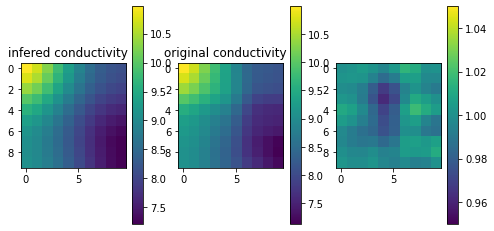

In [151]:
for i in range(1):
    plt.figure()
    result = get_solution(k_param, measurements[i][0])
    fig, axs = plt.subplots(1, 3, figsize = (8,4))
    im1 = axs[0].imshow(result["k"].reshape(dims))
    axs[0].set_title("infered conductivity k")
    im2 = axs[1].imshow(measurements[i][1]["k"].reshape(dims))
    axs[1].set_title("original conductivity k")

    im3 = axs[2].imshow(result["k"].reshape(dims)/jnp.max(result["k"].reshape(dims)) / (measurements[i][1]["k"].reshape(dims) / jnp.max(measurements[i][1]["k"].reshape(dims))), vmin = 0.95, vmax = 1.05)


    plt.colorbar(im1, ax = axs[0])
    plt.colorbar(im2, ax = axs[1])
    plt.colorbar(im3, ax = axs[2])

In [152]:
jnp.max(jnp.abs(result["k"].reshape(dims)/jnp.sum(result["k"].reshape(dims)) / (measurements[i][1]["k"].reshape(dims) / jnp.sum(measurements[i][1]["k"].reshape(dims))) - 1)) * 100

Array(3.40433996, dtype=float64)

In [153]:
jnp.max(jnp.abs(result["k"].reshape(dims) / (measurements[i][1]["k"].reshape(dims)) - 1)) * 100

Array(3.91435063, dtype=float64)

---